### Imports

In [1]:
import numpy as np
import numpy.matlib as matl
from sklearn import mixture
from sklearn import cluster
from matplotlib.colors import ListedColormap
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

### Funciones para crear los datos y para dibujar

In [2]:
def rota_datos_alrededor_origen(X, angulo):
    angle_rad = angulo*2.0*np.pi/360.0

    s = np.sin(angle_rad)
    c = np.cos(angle_rad)
    matriz_rotacion = np.array([[c,-s],[s,c]])
    X_rotados = np.dot(matriz_rotacion, X) # se rotan los puntos generados

    return X_rotados

In [3]:
def genera_puntos_gausiana2D(Npuntos, media, var1, var2, angulo, display):
    X = np.random.randn(2, Npuntos)
    X[0,:] = X[0,:] * np.sqrt(var1) # se multiplica cada atributo por la
    X[1,:] = X[1,:] * np.sqrt(var2) # raiz cuadrada de la varianza deseada

    X = rota_datos_alrededor_origen(X, angulo)

    X[0,:] = media[0] + X[0,:]
    X[1,:] = media[1] + X[1,:]

    # Display
    if display:
        plt.figure(1)
        plt.plot(X[0,:],X[1,:],'bo',zorder=1)
        plt.grid(True)
        plt.axis('equal')
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()

    return X

In [10]:
def plotModel(X,clf,title):
    color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])

    Y_ = clf.predict(X)
    plt.figure(figsize=(6,6))
    splot = plt.subplot(1, 1, 1)
    if hasattr(clf, "labels_"):
        for i, (label, color) in enumerate(zip(clf.labels_, color_iter)):
            plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 1.4, color=color)
    else:
        params = clf.get_params()
        cov_type = params['covariance_type']
        n_comps = params['n_components']
        if cov_type == 'full':
            cm = clf.covariances_
        elif cov_type == 'spherical':
            cm = clf.covariances_[:,None,None]*np.eye(2)[None,:,:]
        elif cov_type == 'diag':
            cm = clf.covariances_[:,:,None]*np.eye(2)[None,:,:]
        elif cov_type == 'tied':
            cm = clf.covariances_[None,:,:]*np.ones(n_comps)[:,None,None]

        for i, (mean, covar, color) in enumerate(zip(clf.means_, cm, color_iter)):
            v, w = linalg.eigh(covar)
            u = w[0] / linalg.norm(w[0])
            plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 1.4, color=color)

            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / (u[0] + 1.e-20))
            angle = 180 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(mean, v[0]*1.5, v[1]*1.5, angle=180+angle, color=color)
            ell.set_clip_box(splot.bbox)
            ell.set_alpha(0.5)
            splot.add_artist(ell)

    plt.title(title)
    plt.grid(True)
    plt.axis('equal')
    plt.show()

### Clustering mediante el algoritmo EM

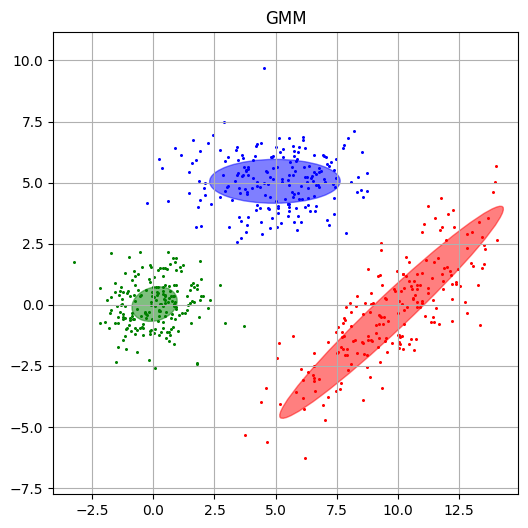

In [11]:
# Number of samples per component:
n_samples = 200

# Generate random sample, two components:
#np.random.seed(0)
X1 = genera_puntos_gausiana2D(n_samples, [0, 0], 1, 1, 45, False)
X2 = genera_puntos_gausiana2D(n_samples, [10, 0], 8, 1, 45, False)
X3 = genera_puntos_gausiana2D(n_samples, [5, 5], 4, 1, 0, False)
X = np.concatenate((X1, X2, X3), axis=1).transpose()

# Fit a mixture of Gaussians with EM:
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full')

gmm.fit(X)

# Plot model:
plotModel(X,gmm,"GMM")

### Validación de clusters: selección del número de componentes con AIC y BIC

Elegir el número óptimo de clusters es un problema no trivial. La primera idea que nos puede venir a la cabeza, elegir el número de componentes que maximiza la función de verosimilitud logarítmica, no funciona porque **la verosimilitud siempre aumenta con el número de clusters**. Cuantas más componentes tiene la mezcla, más capacidad tendrá para ajustarse a los datos del problema. Podemos verlo con el siguiente ejemplo.

Text(0.5, 1.0, 'Log-likelihood')

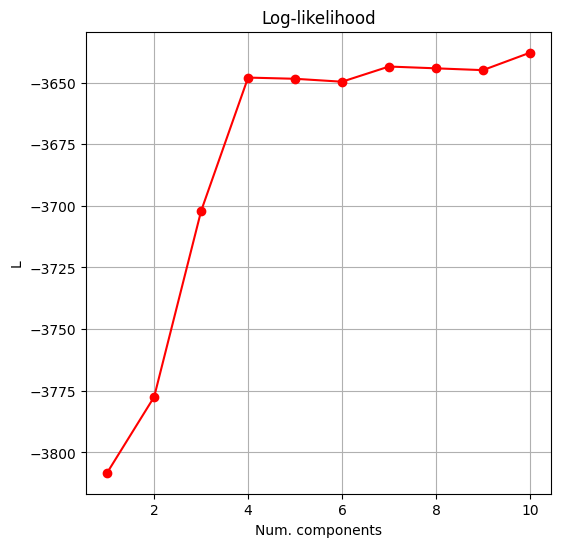

In [8]:
# Number of samples per component:
n_samples = 200

# Generate random sample, 4 components:
X1 = genera_puntos_gausiana2D(n_samples, [0, 0], 4, 1, 45, False)
X2 = genera_puntos_gausiana2D(n_samples, [4, 0], 4, 1, 0, False)
X3 = genera_puntos_gausiana2D(n_samples, [4, 4], 4, 1, 0, False)
X4 = genera_puntos_gausiana2D(n_samples, [0, 4], 9, 1, -45, False)
X = np.concatenate((X1, X2, X3, X4), axis=1).transpose()

# Fit a mixture of Gaussians and compute L:
num_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
L = []
for nc in num_components:
    gmm = mixture.GaussianMixture(n_components=nc, covariance_type='full')
    gmm.fit(X)
    L.append(800*gmm.score(X))

# Plot L vs nc:
plt.figure(figsize=(6,6))
plt.plot(num_components, L, 'ro-')
plt.grid(True)
plt.xlabel("Num. components")
plt.ylabel("L")
plt.title("Log-likelihood")

En la literatura se han propuesto diferentes alternativas a la verosimilitud, que penalizan de algún modo la complejidad de la solución encontrada. Los dos ejemplos más famosos son los criterios **AIC** (Akaike Information Criterion) y **BIC** (Bayesian Information Criterion):

$$
AIC = 2k - 2L
$$

$$
BIC = k \log(n) - 2L
$$

Donde $k$ es el número de parámetros del modelo y $n$ el número de puntos. En ambos casos la verosimilitud logarítmica aparece cambiada de signo, y por tanto la solución elegida será aquella que minimice el criterio utilizado (AIC o BIC).

A continuación se repite el ejemplo anterior usando estos dos criterios.

Num. params = [ 5. 11. 17. 23. 29. 35. 41. 47. 53. 59.]


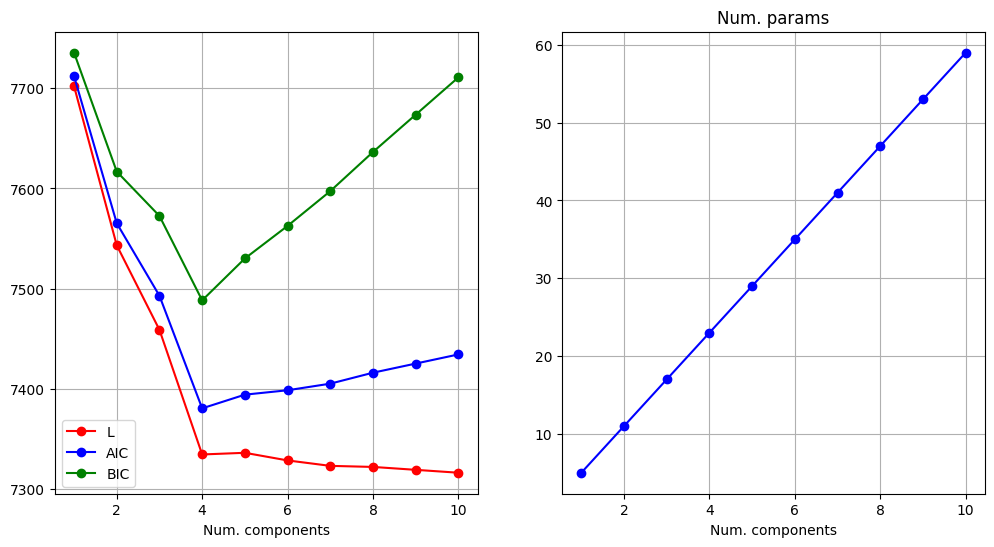

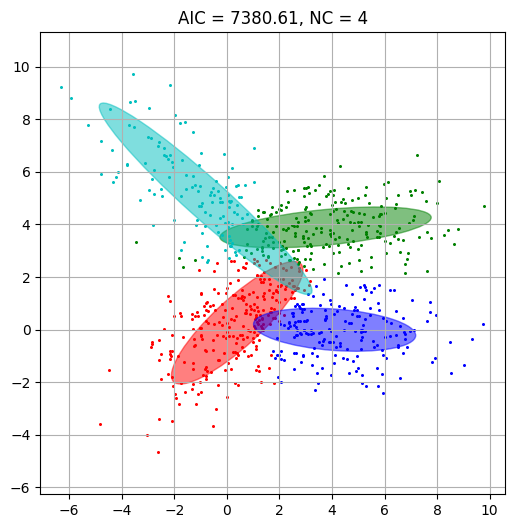

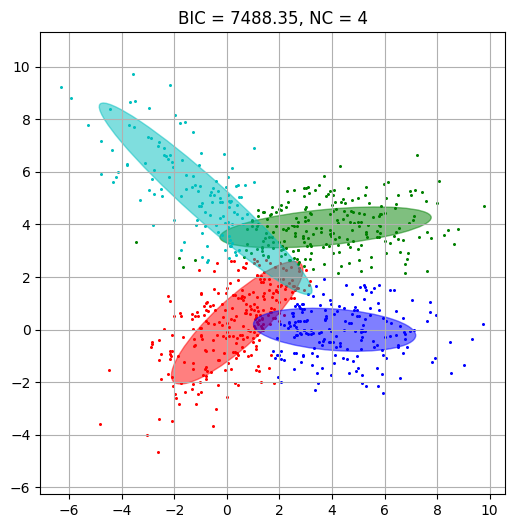

In [13]:
# Number of samples per component:
n_samples = 200

# Generate random sample, 4 components:
X1 = genera_puntos_gausiana2D(n_samples, [0, 0], 4, 1, 45, False)
X2 = genera_puntos_gausiana2D(n_samples, [4, 0], 4, 1, 0, False)
X3 = genera_puntos_gausiana2D(n_samples, [4, 4], 4, 1, 0, False)
X4 = genera_puntos_gausiana2D(n_samples, [0, 4], 9, 1, -45, False)
X = np.concatenate((X1, X2, X3, X4), axis=1).transpose()

# Fit a mixture of Gaussians and compute L, bic and aic:
gmm = {}
min_bic = 1.e100
min_aic = 1.e100
select_bic = 0
select_aic = 0
num_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
L = []
aic = []
bic = []
for nc in num_components:
    gmm[nc] = mixture.GaussianMixture(n_components=nc, covariance_type='full')
    gmm[nc].fit(X)

    L.append(-2.0*4*n_samples*gmm[nc].score(X))
    aic.append(gmm[nc].aic(X))
    bic.append(gmm[nc].bic(X))

    if aic[-1] < min_aic:
        min_aic = aic[-1]
        select_aic = nc

    if bic[-1] < min_bic:
        min_bic = bic[-1]
        select_bic = nc

# Plot L vs nc:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(num_components, L, 'ro-', label="L")
plt.plot(num_components, aic, 'bo-', label="AIC")
plt.plot(num_components, bic, 'go-', label="BIC")
plt.grid(True)
plt.xlabel("Num. components")
plt.legend()

plt.subplot(1,2,2)
plt.plot(num_components, (np.array(aic) - np.array(L))/2.0, 'bo-', label="BIC")
plt.grid(True)
plt.xlabel("Num. components")
plt.title("Num. params")

print("Num. params =", (np.array(aic) - np.array(L))/2.0)

# Plot models for AIC and BIC:
plotModel(X,gmm[select_aic],"AIC = %.2f, NC = %d" % (min_aic,select_aic))
plotModel(X,gmm[select_bic],"BIC = %.2f, NC = %d" % (min_bic,select_bic))

Otra alternativa es hacer validación con un conjunto de puntos que no se hayan usado para construir el modelo, de manera similar a como hacíamos con aprendizaje supervisado.

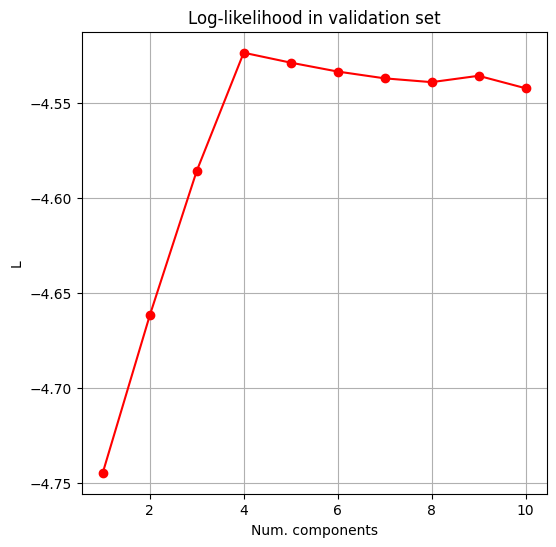

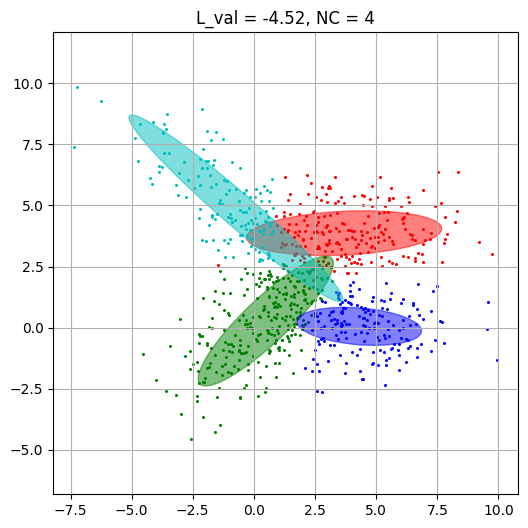

In [14]:
# Number of samples per component:
n_samples = 200

# Generate random sample, 4 components:
X1 = genera_puntos_gausiana2D(n_samples, [0, 0], 4, 1, 45, False)
X2 = genera_puntos_gausiana2D(n_samples, [4, 0], 4, 1, 0, False)
X3 = genera_puntos_gausiana2D(n_samples, [4, 4], 4, 1, 0, False)
X4 = genera_puntos_gausiana2D(n_samples, [0, 4], 9, 1, -45, False)
X = np.concatenate((X1, X2, X3, X4), axis=1).transpose()

# Generate validation sample, 4 components:
X1_val = genera_puntos_gausiana2D(n_samples, [0, 0], 4, 1, 45, False)
X2_val = genera_puntos_gausiana2D(n_samples, [4, 0], 4, 1, 0, False)
X3_val = genera_puntos_gausiana2D(n_samples, [4, 4], 4, 1, 0, False)
X4_val = genera_puntos_gausiana2D(n_samples, [0, 4], 9, 1, -45, False)
X_val = np.concatenate((X1_val, X2_val, X3_val, X4_val), axis=1).transpose()

# Fit a mixture of Gaussians and compute L on validation set:
gmm = {}
max_L_val = -1.e100
select_L_val = 0
num_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
L_val = []
for nc in num_components:
    gmm[nc] = mixture.GaussianMixture(n_components=nc, covariance_type='full')
    gmm[nc].fit(X)

    L_val.append(np.sum(gmm[nc].score(X_val)))

    if L_val[-1] > max_L_val:
        max_L_val = L_val[-1]
        select_L_val = nc

# Plot L vs nc:
plt.figure(figsize=(6,6))
plt.plot(num_components, L_val, 'ro-', label="L_val")
plt.grid(True)
plt.xlabel("Num. components")
plt.ylabel("L")
plt.title("Log-likelihood in validation set")

# Plot model for L_val:
plotModel(X,gmm[select_L_val],"L_val = %.2f, NC = %d" % (max_L_val,select_L_val))

### Clustering mediante el algoritmo K-means

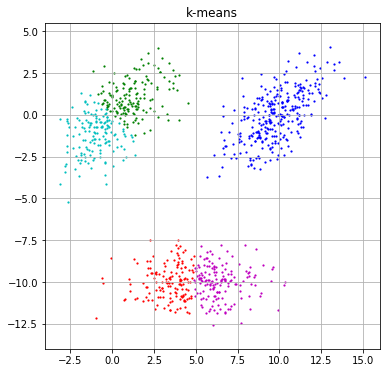

In [ ]:
# Number of samples per component:
n_samples = 300

# Generate random sample, three components:
np.random.seed(0)
X1 = genera_puntos_gausiana2D(n_samples, [0, 0], 4, 1, 45, False)
X2 = genera_puntos_gausiana2D(n_samples, [10, 0], 4, 1, 45, False)
X3 = genera_puntos_gausiana2D(n_samples, [5, -10], 4, 1, 0, False)
X = np.concatenate((X1, X2, X3), axis=1).transpose()

# Cluster with k-means:
clf = cluster.KMeans(n_clusters=5)
clf.fit(X)

# Plot model:
plotModel(X,clf,"k-means")

### Clustering jerárquico

Vamos a usar <a href = "https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">SciPy</a> en lugar de sklearn para hacer clustering jerárquico, porque permite dibujar los dendrogramas con más facilidad y tiene mayor variedad de distancias para probar (por ejemplo en sklearn no se puede hacer single-linkage).


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


In [ ]:
# Number of samples per component:
n_samples = 3

# Generate random sample, three components:
np.random.seed(0)
X1 = genera_puntos_gausiana2D(n_samples, [0, 0], 4, 1, 45, False)
X2 = genera_puntos_gausiana2D(n_samples, [10, 0], 4, 1, 45, False)
X3 = genera_puntos_gausiana2D(n_samples, [5, -10], 4, 1, 0, False)
X = np.concatenate((X1, X2, X3), axis=1).transpose()

# Hierarchichal clustering, single-linkage:
Z = linkage(X, 'single')

In [ ]:
print(Z) # id cluster 1, id cluster2, distance, num. points

[[ 6.          8.          0.83230956  2.        ]
 [ 4.          5.          1.31376242  2.        ]
 [ 7.          9.          1.72675356  3.        ]
 [ 3.         10.          2.21895953  3.        ]
 [ 0.          1.          2.75321974  2.        ]
 [ 2.         13.          3.07117469  3.        ]
 [12.         14.          6.75316773  6.        ]
 [11.         15.          9.4960417   9.        ]]


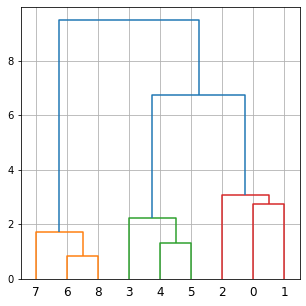

In [ ]:
# Plot the dendrogram:
plt.figure(figsize=(5, 5))
dendrogram(Z, leaf_rotation=0)
plt.grid(True)

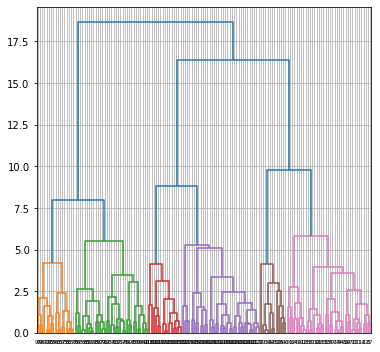

In [ ]:
# Number of samples per component:
n_samples = 50

# Generate random sample, three components:
np.random.seed(0)
X1 = genera_puntos_gausiana2D(n_samples, [0, 0], 4, 1, 45, False)
X2 = genera_puntos_gausiana2D(n_samples, [10, 0], 4, 1, 45, False)
X3 = genera_puntos_gausiana2D(n_samples, [5, -10], 4, 1, 0, False)
X = np.concatenate((X1, X2, X3), axis=1).transpose()

# Hierarchichal clustering, single-linkage:
Z = linkage(X, 'complete')

# Plot the dendrogram:
plt.figure(figsize=(6, 6))
#dendrogram(Z, leaf_rotation=0)
dendrogram(Z, leaf_rotation=0, color_threshold=7.5)
#dendrogram(Z, leaf_rotation=0, truncate_mode='lastp', p=100)
plt.grid(True)

In [ ]:
# Get the final clusters:
max_d = 50
clusters = fcluster(Z, 7.5, criterion='distance')
clusters

array([6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6,
       6, 5, 6, 5, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 5, 5, 5, 6,
       6, 6, 5, 6, 5, 6, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1,
       2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 4, 4, 3, 3, 3, 4, 4, 4, 3, 4,
       3, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 3, 4, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4], dtype=int32)

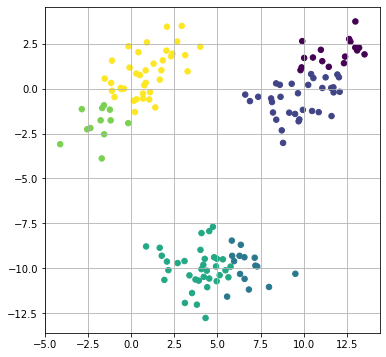

In [ ]:
# Plot the clusters:
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0], X[:,1], c=clusters, s=30)
plt.grid(True)
plt.show()